## Convenient functions for a given listing id 

#### Here we use the cleaned reviews dataset to get all the reviews for each listing. This is handy for displaying top review keywords for a recommended listing.


### 0. Import dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re

from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

RANDOM_STATE= 42

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.downloader.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 1. Prepare data

Here,we load the cleaned reviews dataset, then group comments by listing id to combine all comments for each listing. After that, we tokenize the comments so that comments are ready for generating the word cloud visualization.

In [3]:
# load cleaned review dataset
review_df = pd.read_pickle('../data/data_cleaned/cleaned_review.zip')
print(review_df.shape)

(375173, 4)


In [4]:
# group comments by listing_id
grouped_review = review_df.groupby('listing_id')['comments'].agg(lambda x: ' '.join(x)).reset_index()
print(grouped_review.shape)

(5091, 2)


In [5]:
# use a small sample data to run
sample_review = grouped_review.sample(200, random_state = RANDOM_STATE).reset_index(drop=True)
sample_review.head(2)

,listing_id,comments
0,9803484,Karen was a very gracious hostess. Even though...
1,48629485,Chris and Mollys place was perfect! Very clean...


In [6]:
# tokenize comments
def tokenize_text(text):  
    stop_words = set(stopwords.words("english"))
    # tokenize the text
    text_tokenized = word_tokenize(text)     
    # remove stopwords and non alpha words
    text_removed_sw = [word.lower() for word in text_tokenized if (word.isalpha()) & (word.lower() not in stop_words)]
    joined_text = ' '.join(text_removed_sw)
    
    return joined_text

In [7]:
%%time
# get cleaned comments
sample_review['cleaned_comments'] = sample_review['comments'].apply(lambda x: tokenize_text(x))

CPU times: user 5.15 s, sys: 0 ns, total: 5.15 s
Wall time: 5.15 s


In [8]:
sample_review.head(2)

,listing_id,comments,cleaned_comments
0,9803484,Karen was a very gracious hostess. Even though...,karen gracious hostess even though town visit ...
1,48629485,Chris and Mollys place was perfect! Very clean...,chris mollys place perfect clean cute little s...


### 2. Generate WordCloud

Here we generate a word cloud visualization for a given list id. If the given listing has comments, we will generate a comments word cloud, if not, we will print a message that the given listing has no comments.

In [9]:
def make_wordcloud(df, col, listing_id, stop_words, mask=None):
    
    if listing_id in df['listing_id'].values:
        text = df[df['listing_id'] == listing_id][col].values[0]
        wordcloud = WordCloud(width = 1000, 
                              height = 1000, 
                              stopwords=stop_words, 
                              scale=10, 
                              colormap = 'PuRd', 
                              background_color ='white',
#                               mask = None,
                              max_words=100,
                             ).generate(text)

        plt.figure(figsize=(8,8))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    else:
        print('Oops, this listing currently has no comments.')

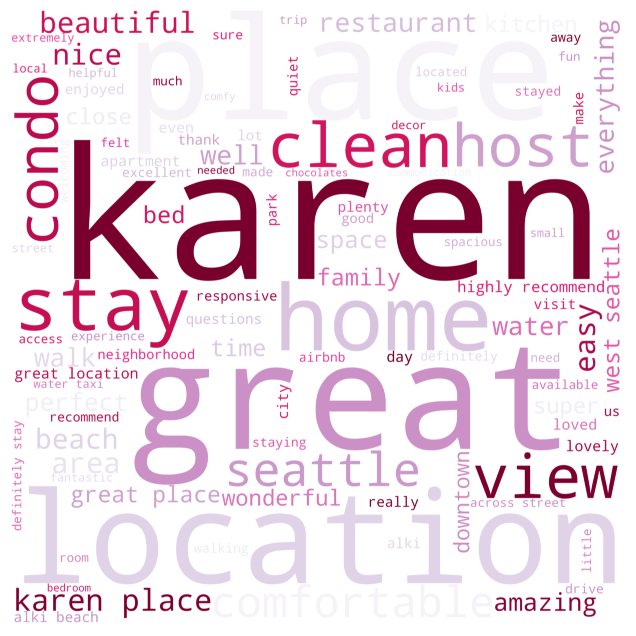

In [10]:
# generate wordcloud for a given listing (the first listing with comments)
stop_words = STOPWORDS
listing_id = sample_review['listing_id'].values[0]
make_wordcloud(sample_review,'cleaned_comments',listing_id, stop_words, mask=None)

In [11]:
# generate wordcloud for a given listing (non-existing listing or lising without comments)
make_wordcloud(sample_review,'cleaned_comments',9803484000, stop_words,  mask=None)

Oops, this listing currently has no comments.


### 3. Review Sentence Sentiment Analyzer

Instead of estimating the sentiment score by the combined reviews of all lists, we estimate the sentiment score by each sentence of each review for a given listing.

In this way, we can better understand review data, especially all useful negative sentences hidden in reviews that have high overall polarity scores, which on't believe provide much insights for users.

Since most of the reviews are highly positive (average score of 4.8 (0-5)), and insights from the quantitative analysis show that users want to know more about the negative reviews hidden in a large number of reviews, we decided to help users quickly identify all the hidden negative content from thousands of comments.

Here we generate review summary report focusing on the hidden nagative reviews.

In [12]:
def get_review_sentiment_report(df,col,listing_id):
    sorted_neg_sentences = np.nan
    if listing_id in df['listing_id'].values:
        comments = df[df['listing_id'] == listing_id]['comments'].values[0]
        if len(comments) <=1:
            print('Oops, this listing currently has no comments.')
        else:
            # segement all comments into sentences for the given listing
            review_sentences = df[df['listing_id'] == listing_id]['comments'].apply(lambda x: re.sub("(<.*?>)|([\t\r])","",x)).str.split('[.?!]').values.tolist()[0]
            review_sentences = [sentence for sentence in review_sentences if sentence]
            num_review_sentences = len(review_sentences)

            # get polarity score for the positives sentences in all the comments
            neg_sentences = []
            for i, text in enumerate(review_sentences):
                sid_obj = SentimentIntensityAnalyzer().polarity_scores(text)
                if (sid_obj['neg'] > 0.2) & (sid_obj['compound'] < -0.1):
                    neg_sentences.append((sid_obj['compound'],sid_obj['neg'],review_sentences[i]))
                else:
                    pass

            neg_percent = (len(neg_sentences)/num_review_sentences)
            non_neg_percent = 1-neg_percent
            # sort the negative sentences first by 'compund' score (ascending order) then by 'neg' score (descending order)
            sorted_neg_sentences = [comment for score1, score2, comment in sorted(neg_sentences, key=lambda x: (x[0], -x[1]))]

            print('------------------')
            print("Overall:")
            print("{}% of all the reviews sentences ({}/{}) on Airbnb for this listing are not negative!".format(round(non_neg_percent*100,2), num_review_sentences-len(neg_sentences),num_review_sentences))
            print("{}% of them ({}/{}) are negative.".format(round(neg_percent*100,2),len(neg_sentences),num_review_sentences))
            print('------------------')
            print("Potentially helpful negative review sentences:")
            print("(Note: some of the negative review sentences might not sound negative to you due to the prediction algorithm used in our model. However, those review sentences are already the most negative ones in all the comments about this rental.)")

            if len(sorted_neg_sentences) >0:
                for i, sentence in enumerate(sorted_neg_sentences):
                    print("{}: {}".format(i+1, sentence))
            else:
                print("Wow, this listing currently doesn't have any negative sentences!")
        return sorted_neg_sentences                    

In [13]:
listing_id = sample_review['listing_id'].values[0]
sorted_neg_sentences = get_review_sentiment_report(sample_review,'comments',listing_id)

------------------
Overall:
99.28% of all the reviews sentences (414/417) on Airbnb for this listing are not negative!
0.72% of them (3/417) are negative.
------------------
Potentially helpful negative review sentences:
(Note: some of the negative review sentences might not sound negative to you due to the prediction algorithm used in our model. However, those review sentences are already the most negative ones in all the comments about this rental.)
1:  With all of the things that were broken in the apartment it made every day use of things extremely difficult
2:  it just made the stay miserable
3:  She’s called twice I had to block her number


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2a50dc6-ff6a-45ff-9dbe-d7a35bd1e393' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>